# DSTEP20 // Assignment #3

assigned : **Jan 23, 2020**

DUE : **Jan 29, 2020 11:59pm**

## Taxis and Ride-hailing Apps in New York City

<img src="http://energyfuse.org/wp-content/uploads/2018/06/130826124911-uber-taxi-app.jpg" width=500>

---

### PART 1 – Background **(10 points)**

Good data science (and data analysis more generally) depends on a clear understanding of the underlying problem/situation, the methods by which the data you are about to analyze are collected, and the situational context in which that data sits.  To that end:

**<u>In your own words</u>, provide a brief (no more than 500 words) descriptive overview of the rise of ride-hailing apps and their effects on traditional taxis in urban environments.**

**Please include *references* within the description via weblinks.**


TEXT FOR YOUR ANSWER HERE.

### PART 2 – Exploring Taxi/Ride-hailing Data **(10 points)**




**Reading: "[Analyzing 1.1 Billion NYC Taxi and Uber Trips, with a Vengeance](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/)"**

The open TLC (Taxi & Limousine Commission) data in NYC can be found through the NYC TLC's official [website](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), however the data is very large and a bit cumbersome, and so we will work with a pre-processed and aggregated CSV file from [Todd W. Schneider](https://toddwschneider.com/about/).  That CSV of the data can be found [here](https://github.com/toddwschneider/nyc-taxi-data/blob/master/analysis/2017_update/data/daily_trips_by_geography.csv?raw=true).

<b>Provide a descriptive overview of the dataset.  Some characteristics to include are:

- a description of what the values in each column represent (i.e., create a data dictionary);

- summary statistics of the data;

- plots (with appropriate captions and axis labels) summarizing the data that show relationships between various columns (e.g., rides of various types over time, bar charts with relative total numbers, scatterplots of various types of vehicles or types of trips with each other etc.</b>

#### Investigate NYC TLC Data Types

In [0]:
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

def init(fname, date_col = None):
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 1000)
  pd.set_option('display.max_colwidth', 100)

  if date_col:
    df_temp = pd.read_csv(fname, parse_dates=[date_col])
  else:
    df_temp = pd.read_csv(fname)
  return df_temp

# -- load the data
url = 'https://github.com/toddwschneider/nyc-taxi-data/blob/master/analysis/2017_update/data/daily_trips_by_geography.csv?raw=true'
df_taxi = init(url, date_col='date')

# -- cleanup
df_taxi['geo'] = df_taxi['geo'].str.replace('total', 'citywide_total')
display(df_taxi.head(2))

,car_type,date,geo,trips,grouping,monthly,parent_type,monthly_is_estimated
0,Gett,2016-04-01,airports,0.0,gett,NaN,Ride-hailing apps,True
1,Gett,2016-04-02,airports,0.0,gett,NaN,Ride-hailing apps,True


In [0]:
def describe(temp_df):
  def red(prt):
    return "\033[31m{}\033[00m".format(prt)
  def grn(prt):
    return "\033[32m{}\033[00m".format(prt)
  def blu(prt):
    return "\033[34m{}\033[00m".format(prt)
  def cyn(prt):
    return "\033[36m{}\033[00m".format(prt)

  data = {}
  data['Key'] = ['car_type', 'geo', 'grouping', 'parent_type', 'date', 'trips', 'monthly', 'monthly_is_estimated']
  data['Type'] = ['String', 'String', 'String', 'String', 'DateTime', 'Float 64', 'Float 64', 'Boolean']
  data['Description'] = ['Type of car used for daily pickup in taxi zone', 
                        'Geographic location of daily pickup',
                        'Grouping of taxi zone for each car type',
                        'Method for ordering a ride',
                        'Datetime of pickup for each taxi zone (daily)',
                        'Number of pickups (daily)',
                        'Number of pickups (monthly)',
                        'Is number or trips (monthly) estimated?']
  data['Data Values'] = [temp_df['car_type'].unique(), 
                        temp_df['geo'].unique(),
                        temp_df['grouping'].unique(),
                        temp_df['parent_type'].unique(),
                        'Range: ' + str(temp_df['date'].min().date()) + ' to ' + str(temp_df['date'].max().date()),
                        'Range: ' + str(temp_df['trips'].min()) + ' to ' + str(temp_df['trips'].max()),
                        'Range: ' + str(temp_df['monthly'].min()) + ' to ' + str(temp_df['monthly'].max()),
                        'True or False']
  df_data = pd.DataFrame(data)

  # -- https://stackoverflow.com/questions/17232013/how-to-set-the-pandas-dataframe-data-left-right-alignment
  dfStyler = df_data.style.set_properties(**{'text-align': 'left'})
  display(dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))

  total_days = blu(format(len(temp_df.groupby(['date'])), ',d'))

  print('\n\nThe dataset represents daily data collected over {0} days.'.format(total_days))
  for col in ['car_type', 'geo', 'trips', 'grouping', 'monthly', 'parent_type']:
    total_col = blu(format(len(temp_df[col].unique()), ',d'))
    if temp_df[col].dtype == np.object:  
      temp_ds = temp_df.groupby([col]).sum().sort_values('trips', ascending=False)['trips']
      offset = 0
      if temp_ds.index[0] == 'total':
        offset = 1
      high_col = blu(temp_ds.index[offset] + ' ({:,} trips)'.format(int(temp_ds[offset])))
      low_col = blu(temp_ds.index[::-1][0] + ' ({:,} trips)'.format(int(temp_ds[::-1][0])))
      print('There are {0} unique items in the {1} column with {2} having the highest occurance and {3} the least.'.format(total_col, grn(col), high_col, low_col))
  trips_max = temp_df['trips'].max()
  trips_max_type = temp_df[temp_df['trips'] == trips_max].reset_index()['car_type'][0]
  trips_max_date = temp_df[temp_df['trips'] == trips_max].reset_index()['date'][0].date()
  print('The most trips recorded by a taxi zone was {0} on {1} with {2}'.format(blu(format(int(trips_max), ',d')), blu(trips_max_date), grn(trips_max_type)))
  
  return(df_data)

df_taxi_desc = describe(df_taxi.copy())

,Key,Type,Description,Data Values
0,car_type,String,Type of car used for daily pickup in taxi zone,['Gett' 'Green taxis' 'Juno' 'Lyft' 'Non-app FHVs' 'Uber' 'Via' 'Yellow taxis']
1,geo,String,Geographic location of daily pickup,['airports' 'manhattan' 'manhattan_hub' 'outer_boroughs_ex_airports' 'citywide_total']
2,grouping,String,Grouping of taxi zone for each car type,['gett' 'green' 'juno' 'lyft' 'other' 'uber_2014' 'uber' 'via' 'yellow']
3,parent_type,String,Method for ordering a ride,['Ride-hailing apps' 'Taxis' 'Other']
4,date,DateTime,Datetime of pickup for each taxi zone (daily),Range: 2009-01-01 to 2017-12-31
5,trips,Float 64,Number of pickups (daily),Range: 0.0 to 849414.0
6,monthly,Float 64,Number of pickups (monthly),Range: 0.0 to 14711971.0
7,monthly_is_estimated,Boolean,Is number or trips (monthly) estimated?,True or False




The dataset represents daily data collected over 3,287 days.
There are 8 unique items in the car_type column with Yellow taxis (3,734,218,150 trips) having the highest occurance and Gett (3,348,947 trips) the least.
There are 5 unique items in the geo column with citywide_total (1,873,400,094 trips) having the highest occurance and airports (63,439,578 trips) the least.
There are 9 unique items in the grouping column with yellow (3,734,218,150 trips) having the highest occurance and gett (3,348,947 trips) the least.
There are 3 unique items in the parent_type column with Taxis (3,862,893,698 trips) having the highest occurance and Other (95,983,797 trips) the least.
The most trips recorded by a taxi zone was 849,414 on 2010-09-19 with Yellow taxis


#### Exploring The NYC TLC Data

In [0]:
df_taxi = df_taxi.drop(columns=['monthly', 'monthly_is_estimated'])

##### Totals - Overall

Text(0, 0.5, 'Total Number of Trips (millions)')

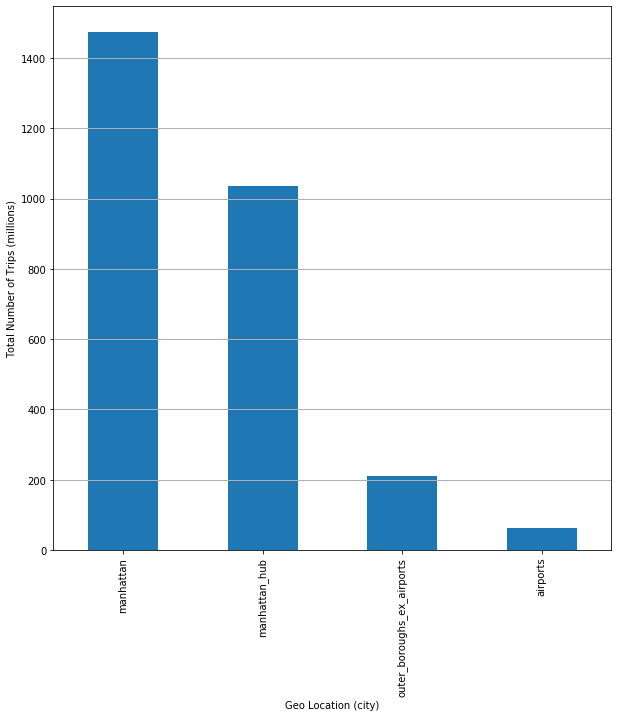

In [0]:
# -- sum the totals by geo
taxi_geo_totals = df_taxi[df_taxi['geo'] != 'citywide_total'].groupby(['geo']).sum()

# -- sort totals descending
df_taxi_geo_totals = taxi_geo_totals.sort_values('trips', ascending=False)

# -- cleanup
df_taxi_geo_totals['trips'] = df_taxi_geo_totals['trips'] / 1000000.0

# -- plot geo totals
ax = df_taxi_geo_totals.plot.bar(y='trips', use_index=True, legend=False, figsize=[10, 10])
ax.grid(axis='y', which='major', lw=1)
ax.set_xlabel('Geo Location (city)')
ax.set_ylabel('Total Number of Trips (millions)')


Text(0, 0.5, 'Number of Trips (millions)')

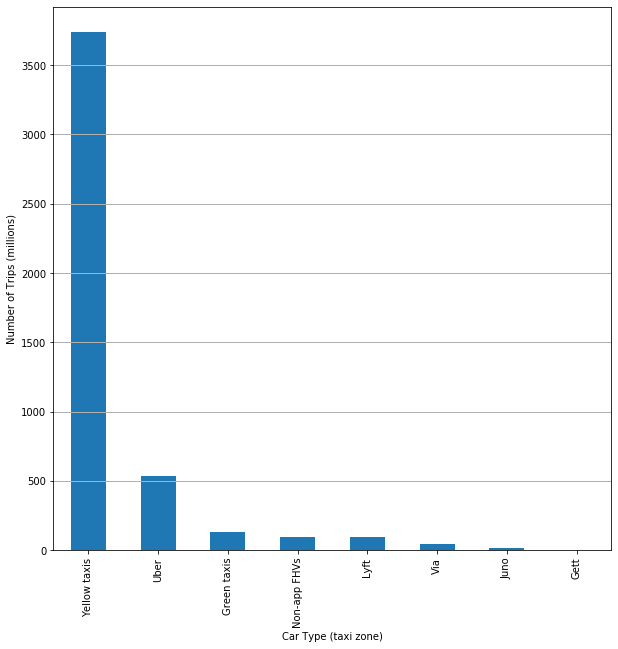

In [0]:
# -- sum the totals
taxi_car_type_totals = df_taxi.groupby(['car_type']).sum()

# -- sort totals descending
df_taxi_car_type_totals = taxi_car_type_totals.sort_values('trips', ascending=False)

# -- cleanup
df_taxi_car_type_totals['trips'] = df_taxi_car_type_totals['trips'] / 1000000.0

# -- plot totals
ax = df_taxi_car_type_totals.plot.bar(y='trips', use_index=True, legend=False, figsize=[10, 10])
ax.grid(axis='y', which='major', lw=1)
ax.set_xlabel('Car Type (taxi zone)')
ax.set_ylabel('Number of Trips (millions)')

Text(0, 0.5, 'Number of Trips (millions)')

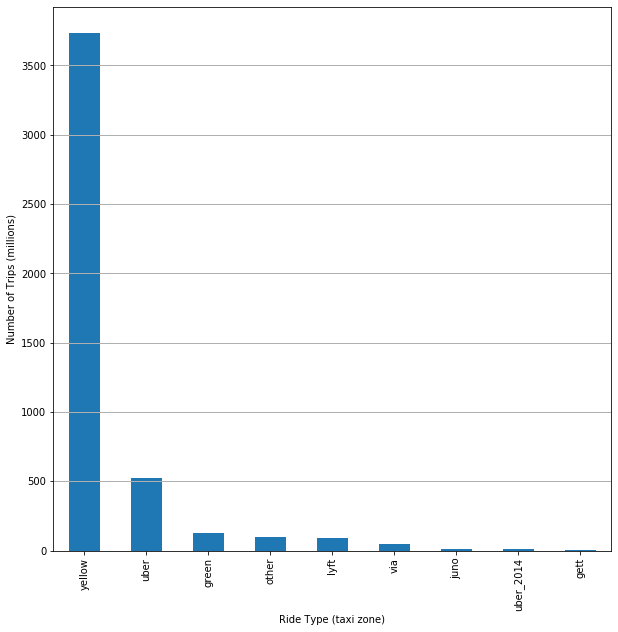

In [0]:
# -- sum the totals
taxi_car_type_totals = df_taxi.groupby(['grouping']).sum()

# -- sort totals descending
df_taxi_car_type_totals = taxi_car_type_totals.sort_values('trips', ascending=False)

# -- cleanup
df_taxi_car_type_totals['trips'] = df_taxi_car_type_totals['trips'] / 1000000.0

# -- plot totals
ax = df_taxi_car_type_totals.plot.bar(y='trips', use_index=True, legend=False, figsize=[10, 10])
ax.grid(axis='y', which='major', lw=1)
ax.set_xlabel('Ride Type (taxi zone)')
ax.set_ylabel('Number of Trips (millions)')

Text(0, 0.5, 'Number of Trips (millions)')

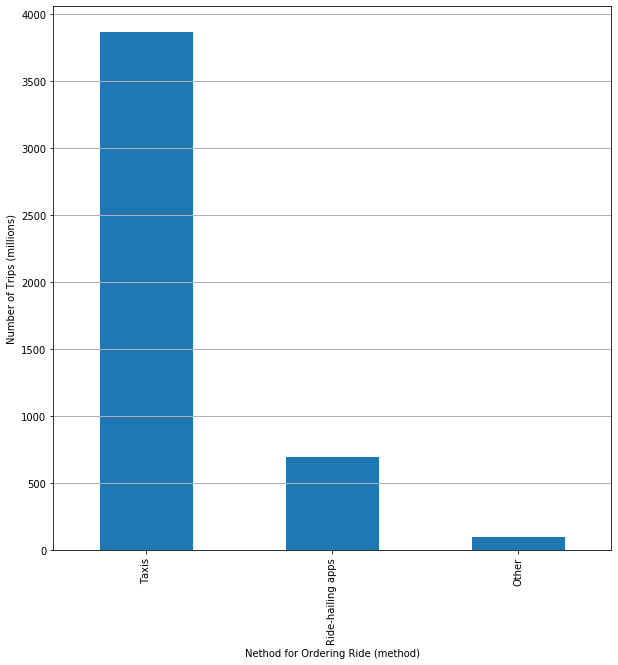

In [0]:
# -- sum the totals
taxi_car_type_totals = df_taxi.groupby(['parent_type']).sum()

# -- sort totals descending
df_taxi_car_type_totals = taxi_car_type_totals.sort_values('trips', ascending=False)

# -- cleanup
df_taxi_car_type_totals['trips'] = df_taxi_car_type_totals['trips'] / 1000000.0

# -- plot totals
ax = df_taxi_car_type_totals.plot.bar(y='trips', use_index=True, legend=False, figsize=[10, 10])
ax.grid(axis='y', which='major', lw=1)
ax.set_xlabel('Nethod for Ordering Ride (method)')
ax.set_ylabel('Number of Trips (millions)')

In [0]:
df_taxi_ts = df_taxi.groupby(['date']).sum()
display(df_taxi_ts[27:28])
df_taxi_ts_28 = df_taxi_ts.rolling(window = 28).sum()
display(df_taxi_ts_28[27:28])

,trips,monthly,monthly_is_estimated
date,,,
2009-01-28,1201926.0,32806758.0,0.0


,trips,monthly,monthly_is_estimated
date,,,
2009-01-28,32806758.0,32806758.0,0.0


In [0]:
display(df_taxi_ts[27:28])
df_taxi_ts[:28].sum()

,trips,monthly,monthly_is_estimated
date,,,
2009-01-28,1201926.0,32806758.0,0.0


trips                   32806758.0
monthly                 32806758.0
monthly_is_estimated           0.0
dtype: float64

In [0]:
display(df_taxi_ts[55:56])
df_taxi_ts[28:56].sum()

,trips,monthly,monthly_is_estimated
date,,,
2009-02-25,1280763.0,35251913.0,0.0


trips                    35251913.0
monthly                 969888002.0
monthly_is_estimated            0.0
dtype: float64

In [0]:
df_taxi_ts = df_taxi.groupby(['trips', 'date']).sum()
df_taxi_ts.tail()


,,monthly,monthly_is_estimated
trips,date,,
694727.0,2010-09-25,12833272.0,0.0
725850.0,2010-09-24,13845003.0,0.0
763954.0,2010-09-25,14193204.0,0.0
765588.0,2010-09-19,11399139.0,0.0
849414.0,2010-09-19,12648709.0,0.0


#### Time Series - Total Taxi Demand

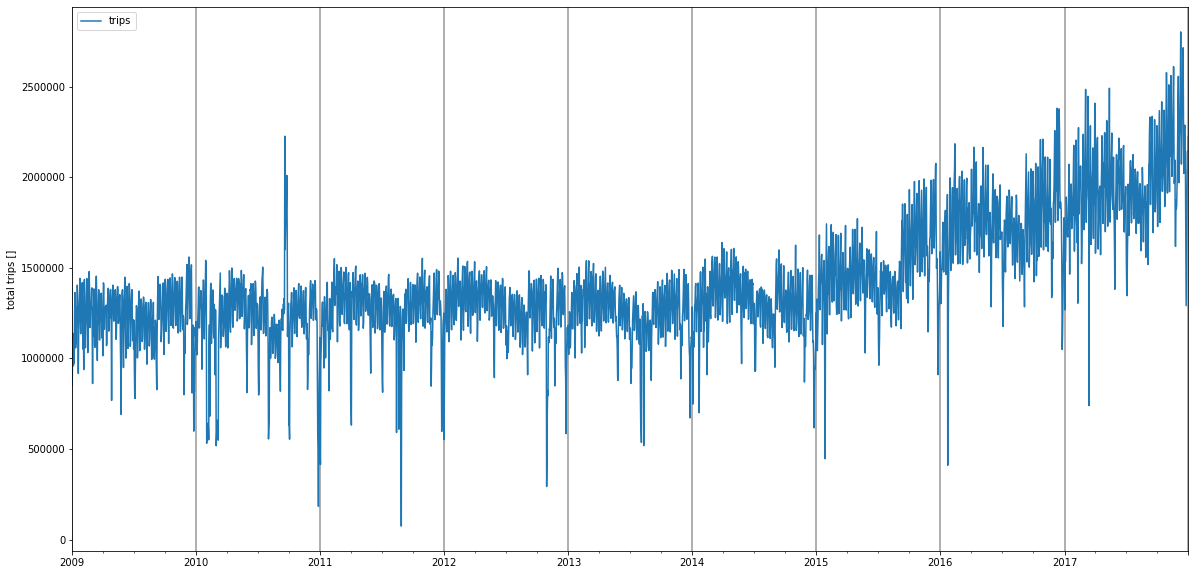

In [0]:
# -- geo location over time
df_taxi_ts = df_taxi.groupby(['date']).sum()

# -- plot 
ax = df_taxi_ts.plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="upper left")

In [0]:
df_taxi_geo_ts.head()

trips  monthly  monthly_is_estimated
geo      date                                              
airports 2009-01-01  10021.0      0.0                   0.0
         2009-01-02  12600.0      0.0                   0.0
         2009-01-03  11989.0      0.0                   0.0
         2009-01-04  16909.0      0.0                   0.0
         2009-01-05  17051.0      0.0                   0.0

#### Time Series - Geo

In [0]:
df_taxi.head(2)

,car_type,date,geo,trips,grouping,parent_type
0,Gett,2016-04-01,airports,0.0,gett,Ride-hailing apps
1,Gett,2016-04-02,airports,0.0,gett,Ride-hailing apps


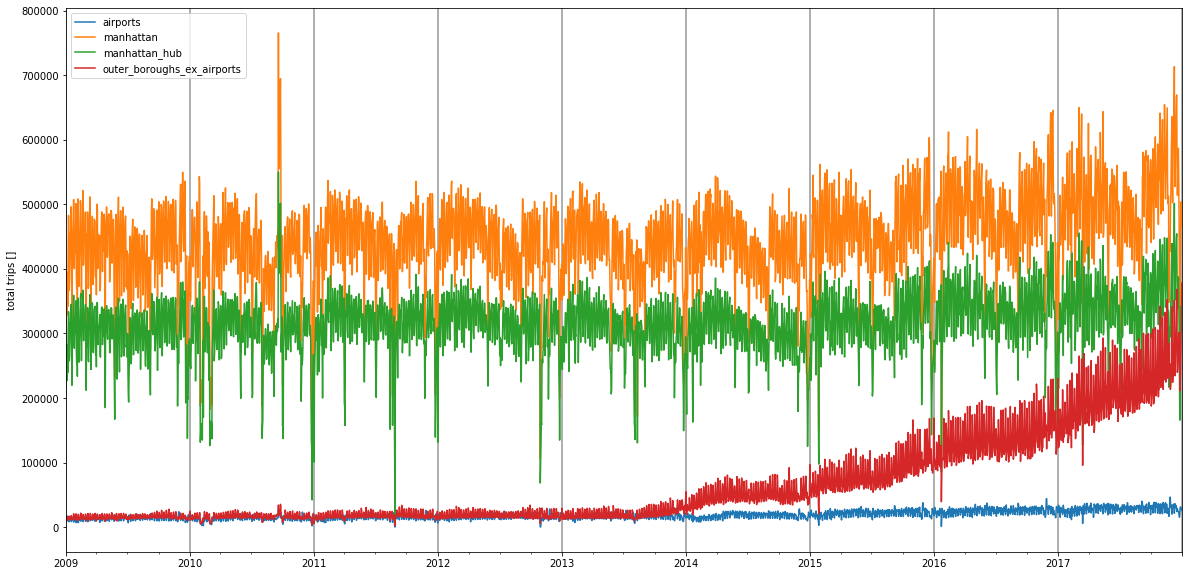

In [0]:
# -- geo location over time
df_taxi_geo_ts = df_taxi[df_taxi['geo'] != 'citywide_total'].groupby(['geo', 'date']).sum()

# -- plot 
ax = df_taxi_geo_ts.unstack('geo').plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="upper left")

Data from 2013 onward interesting

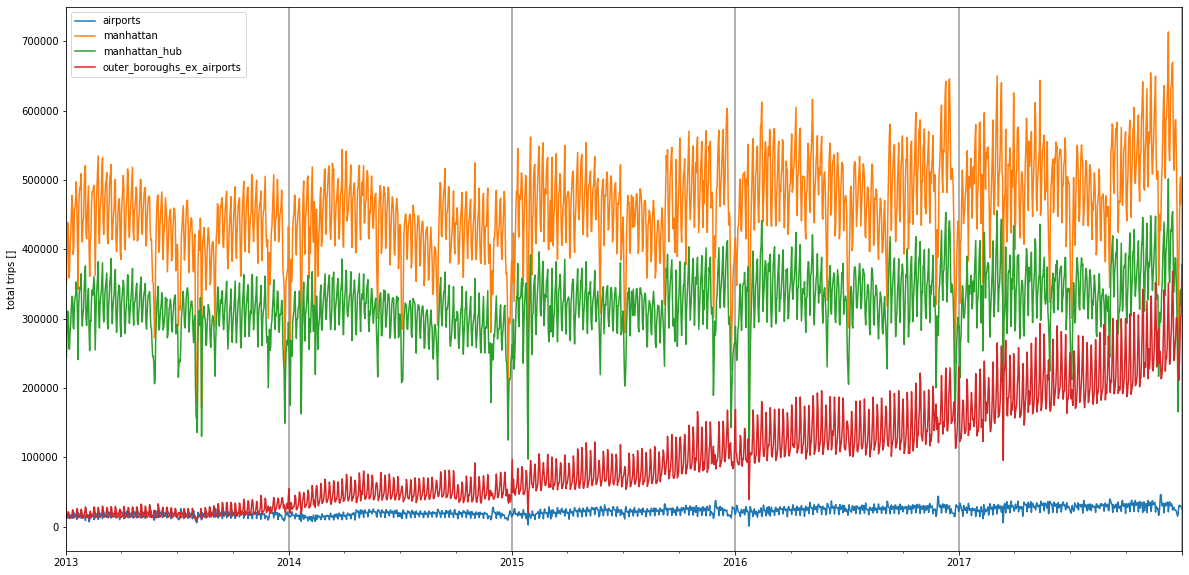

In [0]:
# -- geo location over time
df_taxi_geo_ts = df_taxi[(df_taxi['geo'] != 'citywide_total') & (df_taxi['date'] > '2012-12-31')].groupby(['geo', 'date']).sum()

# -- plot 
ax = df_taxi_geo_ts.unstack('geo').plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="upper left")


#### Time Series - Car Type

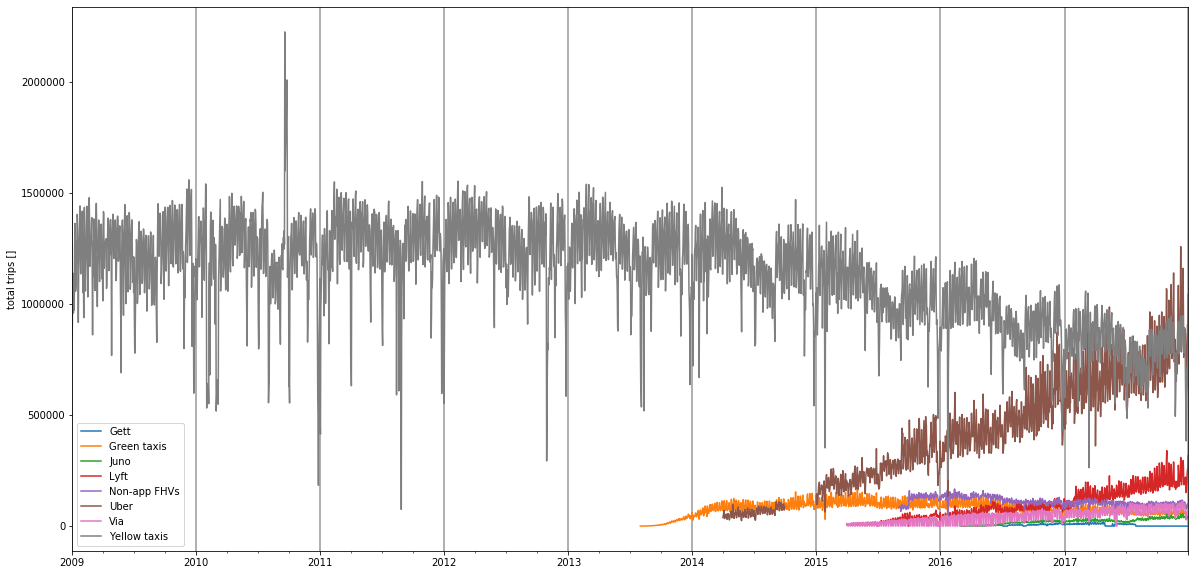

In [0]:
# -- geo location over time
df_taxi_car_type_ts = df_taxi.groupby(['car_type', 'date']).sum()

# -- plot 
ax = df_taxi_car_type_ts.unstack('car_type').plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="lower left")

Data from 2013 onward seems interesting

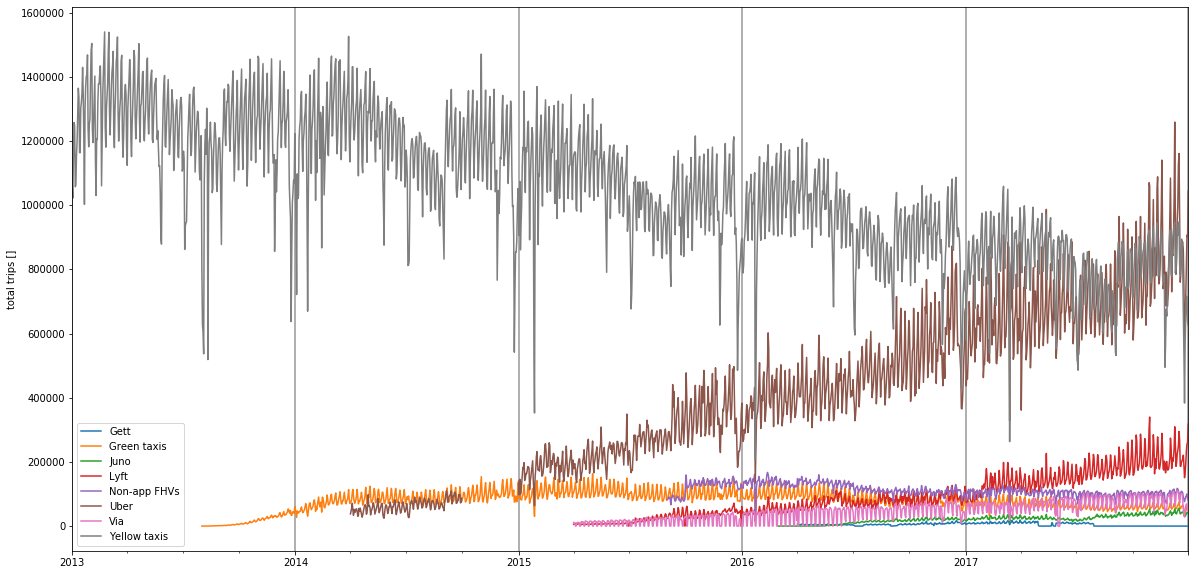

In [0]:
# -- geo location over time
df_taxi_car_type_ts = df_taxi[df_taxi['date'] > '2012-12-31'].groupby(['car_type', 'date']).sum()

# -- plot 
ax = df_taxi_car_type_ts.unstack('car_type').plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="lower left")

In [0]:
yellow_down = df_taxi_car_type_ts.unstack('car_type')[df_taxi_car_type_ts.unstack('car_type')['trips', 'Yellow taxis'] < df_taxi_car_type_ts.unstack('car_type')['trips', 'Uber']]
print('For years, the Yellow Taxi has been the most used taxi car for all trips; However, on {0}, Uber surpassed Yellow Taxi for the first time.'.format(blu(yellow_down.index[0].date())))

For years, the Yellow Taxi has been the most used taxi car for all trips; However, on 2017-03-14, Uber surpassed Yellow Taxi for the first time.


#### Time Series - Grouping

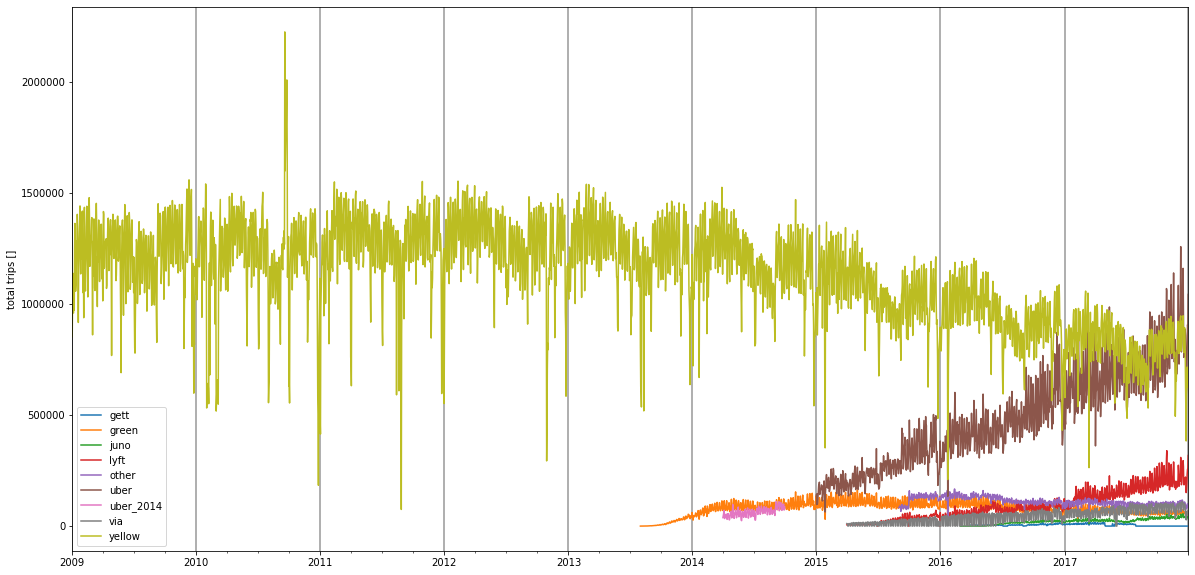

In [0]:
# -- geo location over time
df_taxi_grouping_ts = df_taxi.groupby(['grouping', 'date']).sum()

# -- plot 
ax = df_taxi_grouping_ts.unstack('grouping').plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="lower left")

Data from 2013 onward seems interesting

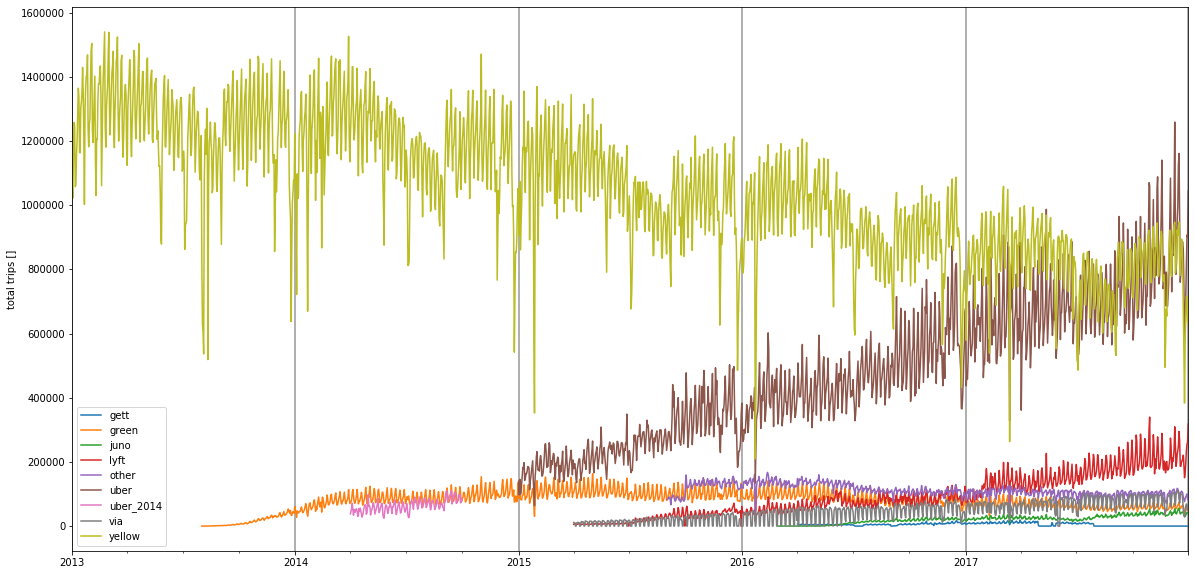

In [0]:
# -- geo location over time
df_taxi_grouping_ts = df_taxi[df_taxi['date'] > '2012-12-31'].groupby(['grouping', 'date']).sum()

# -- plot 
ax = df_taxi_grouping_ts.unstack('grouping').plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="lower left")

In [0]:
yellow_down = df_taxi_grouping_ts.unstack('grouping')[df_taxi_grouping_ts.unstack('grouping')['trips', 'yellow'] < df_taxi_grouping_ts.unstack('grouping')['trips', 'uber']]
print('For years, the Yellow Taxi has been the most used taxi car for all trips; However, on {0}, Uber surpassed Yellow Taxi for the first time.'.format(blu(yellow_down.index[0].date())))

For years, the Yellow Taxi has been the most used taxi car for all trips; However, on 2017-03-14, Uber surpassed Yellow Taxi for the first time.


#### Time Series - Parent Type

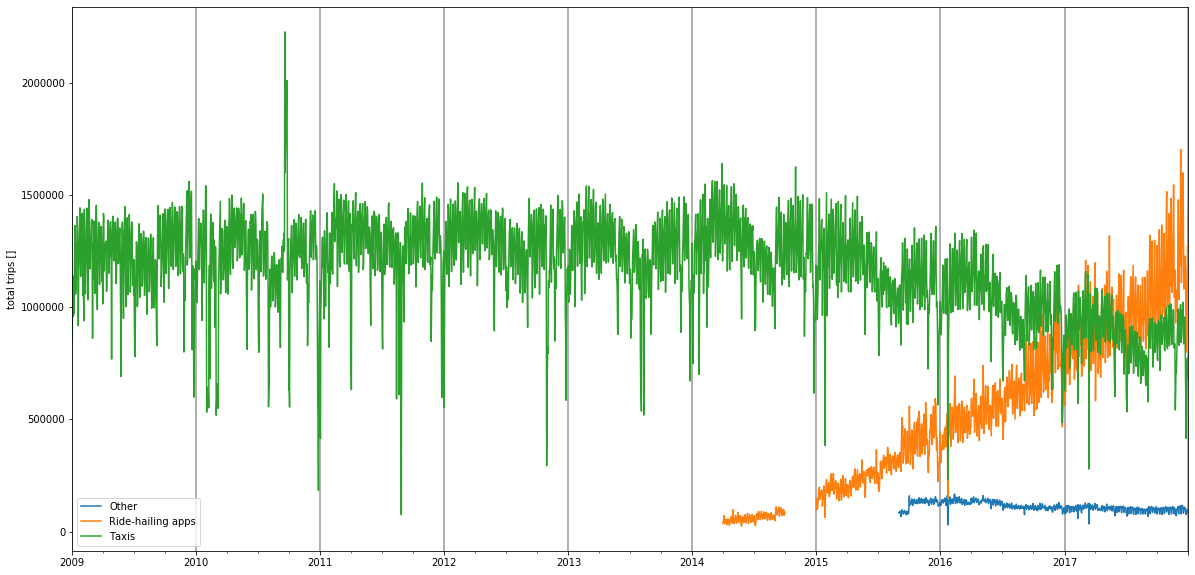

In [0]:
# -- geo location over time
df_taxi_parent_ts = df_taxi.groupby(['parent_type', 'date']).sum()

# -- plot 
ax = df_taxi_parent_ts.unstack('parent_type').plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="lower left")

Data from 2013 onward seems interesting

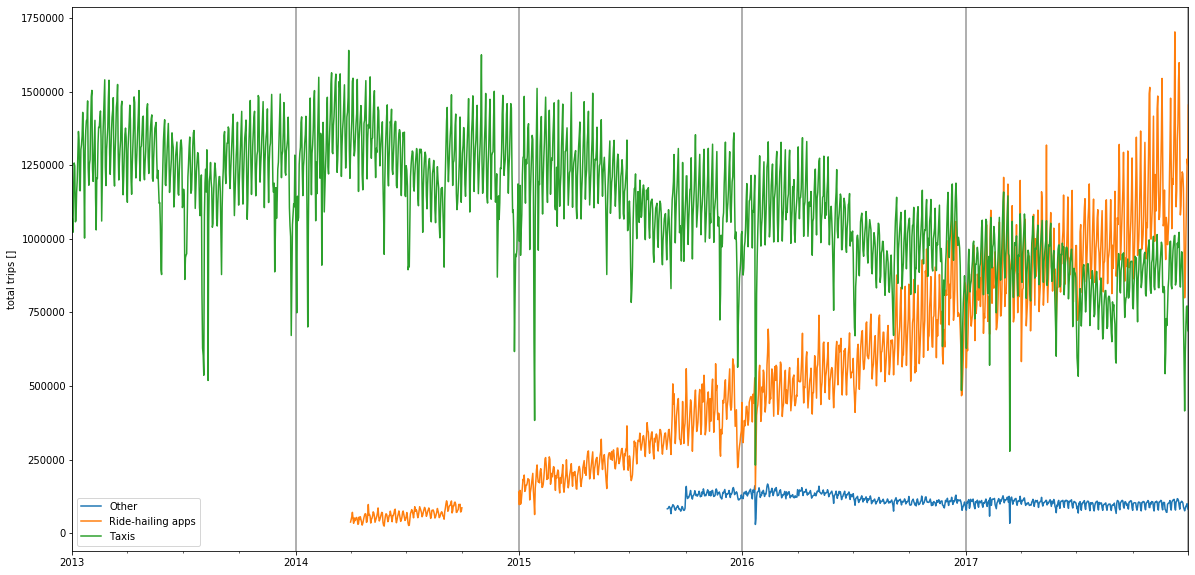

In [0]:
# -- geo location over time
df_taxi_parent_ts = df_taxi[df_taxi['date'] > '2012-12-31'].groupby(['parent_type', 'date']).sum()

# -- plot 
ax = df_taxi_parent_ts.unstack('parent_type').plot(y = 'trips', figsize = [20,10])
ax.grid(axis="x", which="major", lw=2)
ax.set_xlabel("")
ax.set_ylabel("total trips []")
ax.legend(loc="lower left")

In [0]:
yellow_down = df_taxi_parent_ts.unstack('parent_type')[df_taxi_parent_ts.unstack('parent_type')['trips', 'Taxis'] < df_taxi_parent_ts.unstack('parent_type')['trips', 'Ride-hailing apps']]
print('For years, the Yellow Taxi has been the most used taxi car for all trips; However, on {0}, Uber surpassed Yellow Taxi for the first time.'.format(blu(yellow_down.index[0].date())))

For years, the Yellow Taxi has been the most used taxi car for all trips; However, on 2016-12-31, Uber surpassed Yellow Taxi for the first time.


In [0]:
yellow_down.head()

trips                            
parent_type     Other Ride-hailing apps     Taxis
date                                             
2016-12-31    97592.0          850414.0  829733.0
2017-01-01    86418.0          838881.0  809774.0
2017-01-07    84922.0          880738.0  866955.0
2017-01-23   109123.0          834617.0  833268.0
2017-02-05    91192.0          928375.0  877800.0

### PART 3 – Analysis of Taxi/Ride-hailing Time Series Data **(10 points)**




As we did with time series data in class, we'd like to answer two fundamental questions:

<b>

1. what is the relationship between Taxis and Ride-hailing alternatives in NYC?

2. is there periodicity in the (various kinds of) trip data?

</b>

While we are asking these questions in a very different context, the purpose of these questions is same <small>(note the transferability of these tools across different domains)</small>.  Namely to assess the potential impact of one modality on another, and how might we anticipate resource allocation for demand.

**Using the time series analysis techniques we developed in class, present quantitative evidence with supporting visualizations that address the two questions above.**

### PART 4 – Summary of Findings **(10 points)**




**Summarize (no more than 500 words) your findings in this notebook by briefly reviewing the summary of the data set that you developed in Part 2 and provide answers to the two questions in Part 3 using the quantitative metrics and visualizations that you found as evidence to support your claims.  As always, include a description of limitations and potential biases in your analysis.**

TEXT FOR YOUR ANSWER HERE.

#### EXTRA CREDIT – Generalizability of results.


**Repeat Part 3 above for the city of Chicago.  The (non-aggregated) taxi trip data can be found [here](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew) and the TNP (Transportation Network Providers) data can be found [here](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p).**

